In [1]:
import zipfile
import os
import os.path 
import nibabel as nib
import numpy as np
import pandas as pd
import shutil
import random
import re

In [2]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)


In [3]:
import nibabel as nib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import glob
import tifffile as tiff
from tifffile import imsave
from PIL import Image
import tensorflow as tf
import cv2 as cv
from PIL import Image
import random

In [4]:
def applyClahe(img):
    clahe = cv.createCLAHE(clipLimit=3.0)
    claheImage = clahe.apply(np.uint8(img*255))
    return claheImage

In [5]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras.preprocessing.image import ImageDataGenerator

In [6]:
pip install segmentation-models-3D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 


In [7]:
import segmentation_models_3D as sm
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

Segmentation Models: using `tf.keras` framework.


In [8]:
BACKBONE = 'densenet201'


In [9]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import random
import tifffile as tiff
from tifffile import imread

def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name).astype(np.float32)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

  
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
  
  length = len(img_list)

  while True:
    batch_start = 0
    batch_end = batch_size

    while batch_start < length:
      limit = min(batch_end, length)
      X = load_img(img_dir, img_list[batch_start:limit])
      Y = load_img(mask_dir, mask_list[batch_start:limit])

      yield(X, Y)

      batch_start += batch_size
      batch_end += batch_size


In [10]:
import os
import numpy as np
import keras
import tifffile as tiff
from tifffile import imread
import matplotlib.pyplot as plt
import glob
import random

In [11]:
train_img_dir = "/content/drive/MyDrive/3D Segmentation/splitted 75 lim 128 data/train/ctscan/"
train_mask_dir = "/content/drive/MyDrive/3D Segmentation/splitted 75 lim 128 data/train/lim/"

val_img_dir = "/content/drive/MyDrive/3D Segmentation/splitted 75 lim 128 data/val/ctscan/"
val_mask_dir = "/content/drive/MyDrive/3D Segmentation/splitted 75 lim 128 data/val/lim/"

train_img_list= sorted_alphanumeric(os.listdir(train_img_dir))
train_mask_list = sorted_alphanumeric(os.listdir(train_mask_dir))

val_img_list= sorted_alphanumeric(os.listdir(val_img_dir))
val_mask_list = sorted_alphanumeric(os.listdir(val_mask_dir))

In [12]:
batch_size = 1

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)


val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [13]:
img, msk = train_img_datagen.__next__()

In [14]:
print(img.shape)
print(msk.shape)

(1, 128, 128, 128, 3)
(1, 128, 128, 128, 3)


29


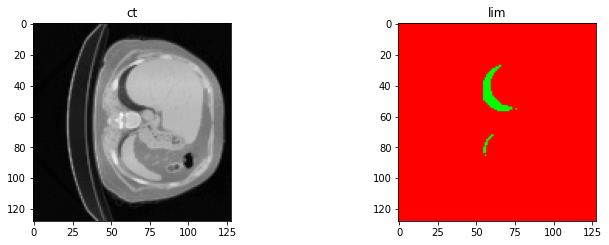

In [15]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]

n_slice=  random.randint(0, test_mask.shape[2])
print(n_slice) #70
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice,0], cmap='gray')
plt.title('ct')
plt.subplot(222)
plt.imshow(test_mask[:,:,n_slice])
plt.title('lim')
plt.show()

In [16]:
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(), sm.losses.DiceLoss(), sm.losses.CategoricalFocalLoss(), sm.losses.JaccardLoss()]
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)
callbacks = [EarlyStopping(monitor='val_loss', patience=250, verbose=1)]

In [17]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [18]:
model = sm.Unet(
                BACKBONE, 
                encoder_weights=None,
                classes = 3,
                activation = 'softmax',
                input_shape = (128,128,128,3))

In [19]:
model.compile(optimizer = optim, loss=total_loss, metrics=metrics)

In [20]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=10000,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks = callbacks
          )

Epoch 1/10000
15/15 [==============================] - 76s 2s/step - loss: 0.7322 - iou_score: 0.2657 - f1-score: 0.3032 - dice_loss: 0.6968 - focal_loss: 0.0353 - jaccard_loss: 0.7947 - val_loss: 0.7777 - val_iou_score: 0.1030 - val_f1-score: 0.2517 - val_dice_loss: 0.7483 - val_focal_loss: 0.0294 - val_jaccard_loss: 0.8316
Epoch 2/10000
15/15 [==============================] - 13s 863ms/step - loss: 0.6013 - iou_score: 0.4972 - f1-score: 0.4130 - dice_loss: 0.5870 - focal_loss: 0.0143 - jaccard_loss: 0.6903 - val_loss: 0.7577 - val_iou_score: 0.1129 - val_f1-score: 0.2670 - val_dice_loss: 0.7330 - val_focal_loss: 0.0247 - val_jaccard_loss: 0.8167
Epoch 3/10000
15/15 [==============================] - 13s 862ms/step - loss: 0.5369 - iou_score: 0.5712 - f1-score: 0.4709 - dice_loss: 0.5291 - focal_loss: 0.0079 - jaccard_loss: 0.6255 - val_loss: 0.7389 - val_iou_score: 0.1304 - val_f1-score: 0.2815 - val_dice_loss: 0.7185 - val_focal_loss: 0.0204 - val_jaccard_loss: 0.8022
Epoch 4/10000

In [21]:
a =history.history['loss']
print(len(a))
#epoch

354


In [22]:
model.save('/content/drive/MyDrive/3D Segmentation/densenet201unetlim75_notf.h5')

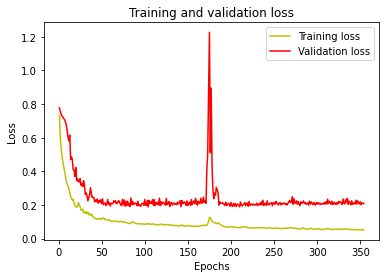

In [23]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

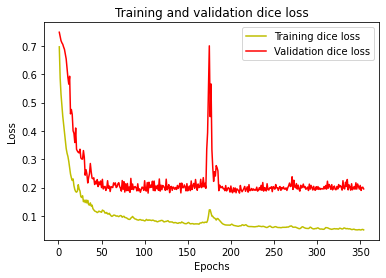

In [24]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['dice_loss']
val_loss = history.history['val_dice_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice loss')
plt.plot(epochs, val_loss, 'r', label='Validation dice loss')
plt.title('Training and validation dice loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

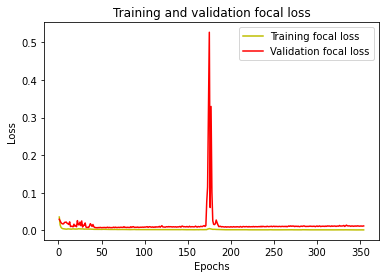

In [25]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['focal_loss']
val_loss = history.history['val_focal_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training focal loss')
plt.plot(epochs, val_loss, 'r', label='Validation focal loss')
plt.title('Training and validation focal loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

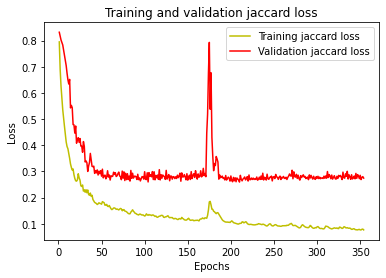

In [26]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['jaccard_loss']
val_loss = history.history['val_jaccard_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training jaccard loss')
plt.plot(epochs, val_loss, 'r', label='Validation jaccard loss')
plt.title('Training and validation jaccard loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

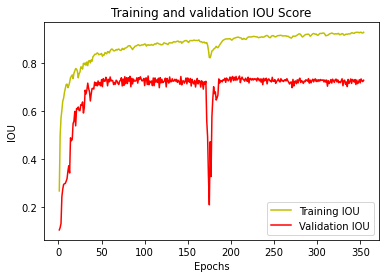

In [27]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU Score')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

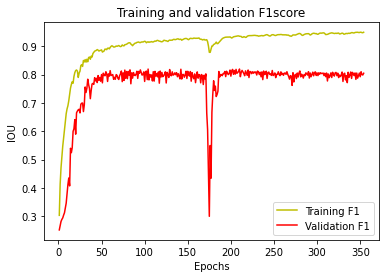

In [28]:
acc = history.history['f1-score']
val_acc = history.history['val_f1-score']
plt.plot(epochs, acc, 'y', label='Training F1')
plt.plot(epochs, val_acc, 'r', label='Validation F1')
plt.title('Training and validation F1score')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [29]:
imgtest, msktest = val_img_datagen.__next__()

In [30]:
model.evaluate(imgtest,msktest)

1/1 [==============================] - 5s 5s/step - loss: 0.2326 - iou_score: 0.6987 - f1-score: 0.7794 - dice_loss: 0.2206 - focal_loss: 0.0121 - jaccard_loss: 0.3066


[0.2326420545578003,
 0.6987335085868835,
 0.7794394493103027,
 0.22056055068969727,
 0.012081504799425602,
 0.3065912127494812]